In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt 
import pymssql
# import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error
import seaborn as sns

2022-12-13 14:35:02.139754: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 14:35:02.139808: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def get_data():
    df=pd.DataFrame()
    try:
        con = pymssql.connect(user='username',password = 'password'
                 ,host='server',database='db',autocommit = True)
    except Exception as e:
        print('unable to make connection',e)
    cur=con.cursor()

    query = """IF OBJECT_ID('TEMPDB..#CLAIMS') IS NOT NULL
DROP TABLE #CLAIMS
SELECT CONVERT(DATE,C.DOS) AS DOS,CLAIM_NO INTO #CLAIMS FROM CLAIMS AS C
JOIN PATIENT AS P ON P.PATIENT_ACCOUNT=C.PATIENT_ACCOUNT
JOIN PRACTICES AS PR ON PR.PRACTICE_CODE=P.PRACTICE_CODE
AND PR.IS_ACTIVE=1 AND ISNULL(PR.IS_TEST_PRACTICE,0)=0
AND ISNULL(PR.EXCLUDE_FROM_BILLING_REPORTS,0) = 0
AND PR.EMR_NAME NOT IN ('CHARTS PRO','PM STANDALONE','TESTINGPRACTICE')
AND PR.PRACTICE_CODE NOT LIKE '9090%' AND PR.PRAC_NAME NOT LIKE '%TEST%'
WHERE ISNULL(C.DELETED,0)=0 AND CONVERT(DATE,C.DOS) BETWEEN '01-01-2020' AND '12-15-2022'----6383824



---------------------------#CHARGES----------------------
IF OBJECT_ID('TEMPDB..#CHARGES') IS NOT NULL
DROP TABLE #CHARGES
SELECT C.Claim_No,CC.claim_charges_id,CC.Amount INTO #CHARGES FROM Claim_Charges AS CC
JOIN #CLAIMS AS C ON CC.Claim_No=C.Claim_No
WHERE ISNULL(CC.DELETED,0)=0------



---------------------------------------------------------
SELECT CONVERT(DATE,C.DOS)AS DOS,COUNT(DISTINCT C.Claim_No) AS CLAIM_COUNT,SUM(CC.Amount) AS CHARGES_SUM FROM #CLAIMS AS C LEFT JOIN #CHARGES AS CC
ON C.Claim_No=CC.Claim_No
GROUP BY CONVERT(DATE,C.DOS)
ORDER BY CONVERT(DATE,C.DOS) ASC;
        """
    try:
        cur.execute(query)
        df=pd.DataFrame(cur.fetchall(),columns=[x[0] for x in cur.description])
#         print(df)
#         df.columns=df.columns.str.upper()
        con.close()
    except:
        print('Error in reading data.....')
        con.close()
    return df

In [3]:
df = get_data()

In [4]:
df.isna().sum()

DOS            0
CLAIM_COUNT    0
CHARGES_SUM    1
dtype: int64

In [5]:
df.head()

,DOS,CLAIM_COUNT,CHARGES_SUM
0,2020-01-01,3279,962075.9100
1,2020-01-02,15600,4003143.5500
2,2020-01-03,14293,3504451.8400
3,2020-01-04,3593,896097.0200
4,2020-01-05,2046,501255.8500


In [6]:
df["DOS"] = pd.to_datetime(df["DOS"])

In [7]:
claim_data = df[["DOS", "CLAIM_COUNT"]]

In [8]:
claim_data = claim_data.set_index('DOS')

In [9]:
len(claim_data)

1076

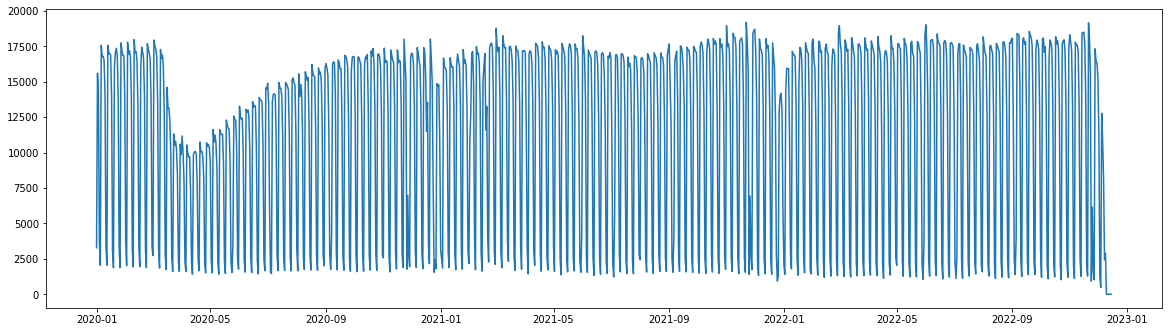

In [10]:
plt.rcParams["figure.figsize"] = (20,5.5)

plt.plot(claim_data)

plt.show()

In [12]:
train = claim_data.loc[:'2022-08-31']
len(train)
# train.head()
test = claim_data.loc['2022-09-01':]
# len(test)
# test.tail()
# train_dates = pd.to_datetime(train['Date'])
# test_dates  = pd.to_datetime(test['Date'])

In [13]:
train.shape

(974, 1)

In [14]:
test.shape

(102, 1)

In [15]:
train.head()

,CLAIM_COUNT
DOS,
2020-01-01,3279
2020-01-02,15600
2020-01-03,14293
2020-01-04,3593
2020-01-05,2046


### Prepare Data

In [16]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train['CLAIM_COUNT'].values.reshape(-1,1))
prediction_days = 365

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [17]:
# x_train

### Build The Model 

In [18]:
model = Sequential()

model.add(LSTM(units =128, activation='relu', return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next value

2022-12-13 14:36:09.852087: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 14:36:09.852317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-13 14:36:09.852533: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-13 14:36:09.852692: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-12-13 14:36:09.852877: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

In [21]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history = model.fit(x_train, y_train, epochs = 200, batch_size=32, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 365, 128)          66560     
                                                                 
 dropout (Dropout)           (None, 365, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 365, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 365, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

18/18 [==============================] - 24s 1s/step - loss: 0.0108 - val_loss: 0.0104
Epoch 151/200
18/18 [==============================] - 25s 1s/step - loss: 0.0100 - val_loss: 0.0110
Epoch 152/200
18/18 [==============================] - 26s 1s/step - loss: 0.0103 - val_loss: 0.0118
Epoch 153/200
18/18 [==============================] - 24s 1s/step - loss: 0.0102 - val_loss: 0.0117
Epoch 154/200
18/18 [==============================] - 23s 1s/step - loss: 0.0113 - val_loss: 0.0108
Epoch 155/200
18/18 [==============================] - 23s 1s/step - loss: 0.0099 - val_loss: 0.0111
Epoch 156/200
18/18 [==============================] - 25s 1s/step - loss: 0.0115 - val_loss: 0.0112
Epoch 157/200
18/18 [==============================] - 24s 1s/step - loss: 0.0106 - val_loss: 0.0110
Epoch 158/200
18/18 [==============================] - 24s 1s/step - loss: 0.0102 - val_loss: 0.0120
Epoch 159/200
18/18 [==============================] - 23s 1s/step - loss: 0.0120 - val_loss: 0.0110
Epoc

### Prediction

In [19]:
actual_temp = test['CLAIM_COUNT'].values
total_temp = pd.concat((train['CLAIM_COUNT'], test['CLAIM_COUNT']),axis=0)

model_inputs = total_temp[len(total_temp)-len(test)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)


# Make Predictions on Test Data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
# print(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

pred = model.predict(x_test)
pred = scaler.inverse_transform(pred)

5/5 [==============================] - 3s 411ms/step


In [20]:
# pred = model.predict(x_test)
# pred = scaler.inverse_transform(pred)

In [21]:
mean_absolute_error(test['CLAIM_COUNT'], pred)

1086.3994881184897

In [22]:
def calcsmape(actual, forecast):
    ytrue = np.array(actual)
    ypred = np.array(forecast)
    return np.mean(np.abs(ytrue - ypred) / ytrue) * 100

In [23]:
calcsmape(test['CLAIM_COUNT'], test['Predictions'])

KeyError: 'Predictions'

In [ ]:
pred_ = test
pred_['CLAIM_COUNT'] = pred

pred_
original = claim_data.loc['2022-01-01':]

In [ ]:
plt.rcParams["figure.figsize"] = (20,5.5)
plt.plot(original.loc['2022-01-01':], color = 'r', label='Actual')
plt.plot(pred_.loc['2022-01-01':], color = 'g', label='Predict')

plt.legend()

In [ ]:
original.head(10)

In [ ]:
pred_.tail(10)

In [ ]:
# pd.to_csv('pred_')

In [ ]:
s=pred_.copy()
t=original.copy()

In [ ]:
s.reset_index(level=0,inplace=True)
t.reset_index(level=0,inplace=True)

In [ ]:
s['week'] = s['DOS'].dt.day_name()
t['week'] = t['DOS'].dt.day_name()

In [ ]:
Y=pd.merge(
    s,
    t,
    how="inner",
    on=['DOS'],
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)
Y.tail()